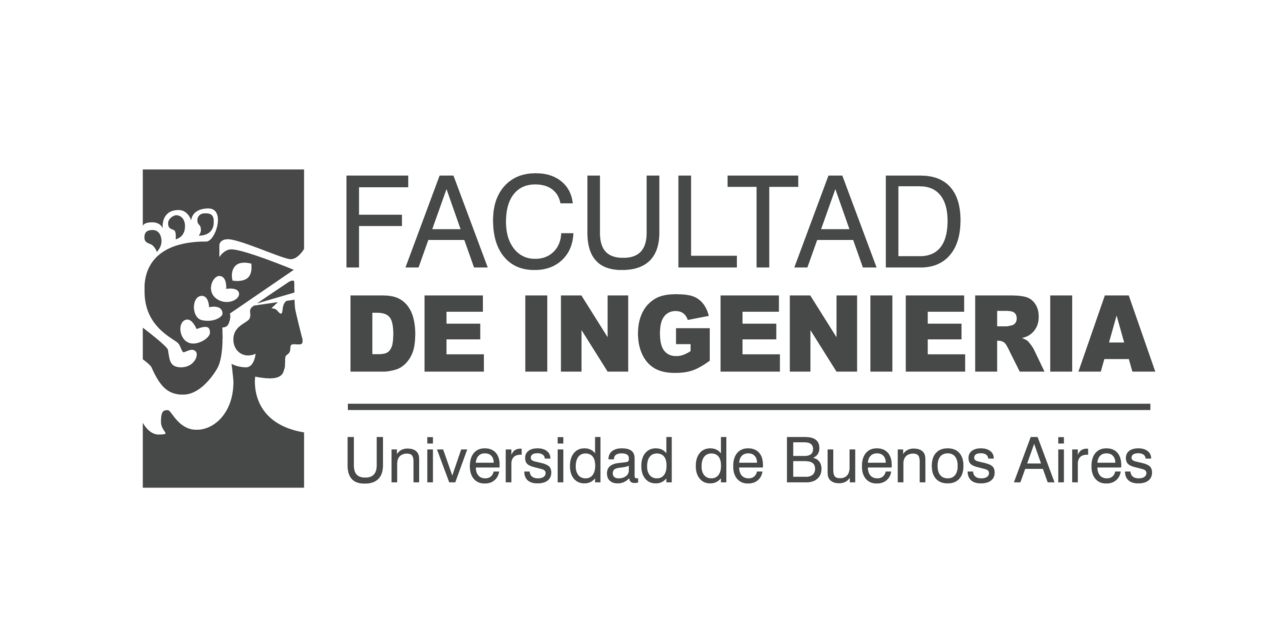

## Visión por Computadora 2 - TP Integrador
### Cohorte 18 - 2do bimestre 2025

**Profesores:** <br />
Ing. Juan Ignacio Cornet - juanignaciocornet@gmail.com <br />
Esp. Ing. Alfonso Rafel - alfonsorafel93@gmail.com <br />
Mg. Ing. Seyed Pakdaman - khodadad.pakdaman@gmail.com <br />

**Alumnos:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />
Ing. Pablo Martin Gomez Verdini - gomezpablo86@gmail.com <br />
Ing. Diego Paciotti Iacchelli - diegopaciotti@gmail.com <br />

**Repositorio Github**<br />
https://github.com/FIUBA-CEIA-18Co2024/VpC2-TP1 <br />

**Consigna**<br />
Ver [consigna](./doc/CONSIGNA.md)

## Prerequisitos y dependencias

In [13]:
from IPython import display
%pip install gdown
%pip install pandas
%pip install numpy
%pip install torch
%pip install torchinfo
%pip install torchvision
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn
%pip install kagglehub
%pip install easyimages
%pip install ipywidgets
display.clear_output()

Imports de librerias utilizadas durnte el trabajo, definición de device (gpu o cpu) y definición de constantes que serán utilizadas en muchas ocasiones.

In [ ]:
import os
import torch
import kagglehub
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from PIL import ImageOps
import torchinfo as torchinfo
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from collections import defaultdict, Counter
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from easyimages import EasyImageList,EasyImage

# USAR GPU SI ES POSIBLE
device = "cuda" if torch.cuda.is_available() else "cpu"

# Path de descarga de datasets usando KaggleHub
os.environ["KAGGLEHUB_CACHE"] = "./"

# PARAMETROS GLOBALES
BATCH_SIZE = 64
WORKERS = 4
DATASET_AUGMENTED_SIZE = 4000

from IPython import display
display.clear_output()

Descarga y descompresión de dataset con imágenes.

In [3]:
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path local al dataset recién descargado:", path)

100%|██████████| 119M/119M [00:04<00:00, 25.2MB/s] 

Extracting files...


Path local al dataset recién descargado: ./datasets/mohamedhanyyy/chest-ctscan-images/versions/1


## Utils

Funciones auxiliares que ayudan a resolver consignas del trabajo. Plotear, contadores, cálculos de media y varianza de canales de colores en imágenes, etc.

In [ ]:
class ResizeWithAspectRatioPadding:
    """
    Clase para redimensionar imágenes manteniendo el aspecto y rellenando con ceros (padding).
    """
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        # Convertimos a tamaño cuadrado manteniendo aspecto
        old_width, old_height = img.size
        ratio = min(self.target_size[0] / old_width, self.target_size[1] / old_height)
        new_size = (int(old_width * ratio), int(old_height * ratio))
        img = img.resize(new_size, resample=Image.BILINEAR)

        delta_w = self.target_size[0] - new_size[0]
        delta_h = self.target_size[1] - new_size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        img = ImageOps.expand(img, padding, fill=0)

        return img

## 1. Preprocesamiento de Datos y EDA

### Analisis exploratorio

A continuación, exploramos la cantidad de elementos del dataset, de sus particiones y las clases. De esta manera, sabremos si contamos con suficiente información para entrenar los modelos y si hay desbalaceo de clases. Además, se inspeccionarán las imagenes de manera visual para entender que tipo de transformaciones serán utiles previo al entrenamiento del modelo y si será necesario aplicar data augementation.

In [5]:
from src.eda import explore_dataset, plot_dataset_distribution

explore_dataset(path + '/Data')


Partición: train
Total de elementos: 613
  Clase 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115 elementos
  Clase 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195 elementos
  Clase 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155 elementos
  Clase 'normal': 148 elementos
Resoluciones distintas en la partición 'train': 482
Primeras 5 resoluciones:
  Resolución: (434, 261)
  Resolución: (309, 248)
  Resolución: (396, 216)
  Resolución: (413, 305)
  Resolución: (425, 279)
Resolución máxima: (1200, 874)
Resolución mínima: (172, 110)

Partición: test
Total de elementos: 315
  Clase 'normal': 54 elementos
  Clase 'adenocarcinoma': 120 elementos
  Clase 'large.cell.carcinoma': 51 elementos
  Clase 'squamous.cell.carcinoma': 90 elementos
Resoluciones distintas en la partición 'test': 272
Primeras 5 resoluciones:
  Resolución: (374, 329)
  Resolución: (446, 354)
  Resolución: (486, 335)
  Resolución: (629, 491)
  Resolución: (439, 260)
Resolución máxima: (940, 627)
Resolución mín

Se observa que hay una gran variedad de resoluciones. Para poder entrenar correctamente las redes a utilizar esto se normalzará en etapas posteriores de esta sección.

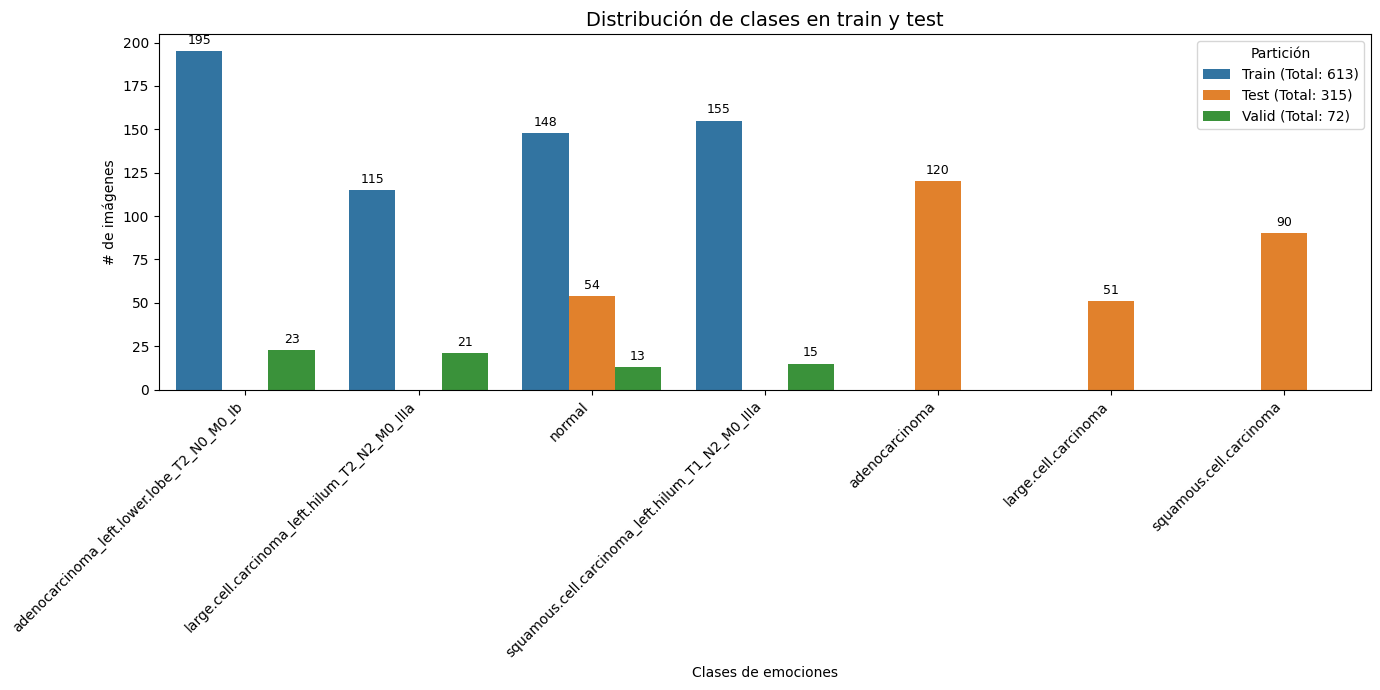

In [6]:
plot_dataset_distribution(path + '/Data')

Como se puede ver en el plot, las clases no estan normalizadas. Deberia haber 4 y ser las mismas a lo largo de las particiones train/test/validation. Se arregla esto generando un nuevo dataset (carpeta *data/dataset*) con el mapeo siguiente.

In [7]:
from src.eda import reorganize_dataset

CLASS_MAP = {
    "adenocarcinoma": "adenocarcinoma",
    "adenocarcinoma_left.lower.lobe": "adenocarcinoma",
    "squamous.cell.carcinoma": "squamous_cell_carcinoma",
    "squamous.cell.carcinoma_left.hilum": "squamous_cell_carcinoma",
    "large.cell.carcinoma": "large_cell_carcinoma",
    "large.cell.carcinoma_left.hilum": "large_cell_carcinoma",
    "normal": "normal"
}

reorganize_dataset(
    source_path= path + '/Data',
    target_path="data/dataset",
    class_map=CLASS_MAP
)

Reorganizando dataset desde: /home/jgonzalez/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1/Data
Guardando en: data/dataset

train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa → large_cell_carcinoma (115 imágenes)
train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib → adenocarcinoma (195 imágenes)
train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa → squamous_cell_carcinoma (155 imágenes)
train/normal → normal (148 imágenes)
test/normal → normal (54 imágenes)
test/adenocarcinoma → adenocarcinoma (120 imágenes)
test/large.cell.carcinoma → large_cell_carcinoma (51 imágenes)
test/squamous.cell.carcinoma → squamous_cell_carcinoma (90 imágenes)
valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa → large_cell_carcinoma (21 imágenes)
valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib → adenocarcinoma (23 imágenes)
valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa → squamous_cell_carcinoma (15 imágenes)
valid/normal → normal (13 imágenes)

Dataset reorganizado correc

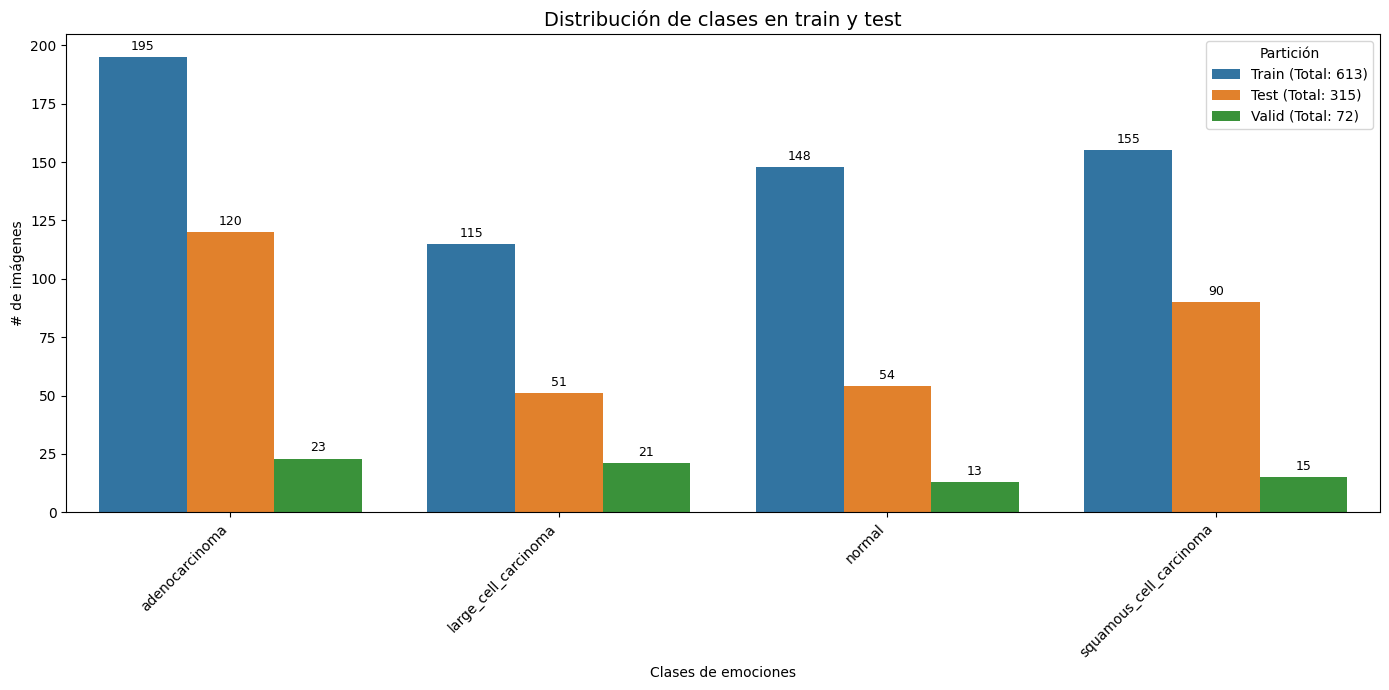

In [8]:
plot_dataset_distribution(dataset_path="data/dataset")

### Transformaciones DataLoaders

In [25]:
"""
Normalizamos las imágenes a un tamaño cuadrado de 224x224
Utilizamos ResizeWithAspectRatioPadding para aplicar el 
resize con padding y mantener la relación de aspecto.
"""
image_size = (224, 224)

# 1- Se aplican distintas transformaciones para el dataset de train y test
train_transform = transforms.Compose([
    transforms.Grayscale(),
    ResizeWithAspectRatioPadding(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Augmentations suaves
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

valid_transform = transforms.Compose([
    transforms.Grayscale(),
    ResizeWithAspectRatioPadding(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    ResizeWithAspectRatioPadding(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# 2- Se cargan los datasets de train y test con las transformaciones
train_dataset = datasets.ImageFolder(root='data/dataset' + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='data/dataset' + '/test', transform=test_transform)
valid_dataset = datasets.ImageFolder(root='data/dataset' + '/valid', transform=valid_transform)

# 3- Se splitea el dataset de train en train y validation para entrenamiento, test se deja para tarea final de evaluación
# Obtener las etiquetas de las imágenes en el dataset de entrenamiento
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
class_weights = {cls: len(targets) / count for cls, count in class_counts.items()}
sample_weights = torch.DoubleTensor([class_weights[label] for label in targets])

# 4 - Sampler balanceado
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=DATASET_AUGMENTED_SIZE,
                                replacement=True)

# 5 - DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=WORKERS, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

# 6 - Info
print(f"Pesos por clase: {class_weights}")
print(f"Tamaño de train dataset original: {len(train_dataset)}")
print(f"Tamaño de train dataset con augmentation: {DATASET_AUGMENTED_SIZE}")
print(f"Tamaño de validation dataset: {len(valid_dataset)}")
print(f"Tamaño de test dataset: {len(test_dataset)}")

Pesos por clase: {0: 3.1435897435897435, 1: 5.3304347826086955, 2: 4.141891891891892, 3: 3.9548387096774196}
Tamaño de train dataset original: 613
Tamaño de train dataset con augmentation: 4000
Tamaño de validation dataset: 72
Tamaño de test dataset: 315


In [10]:
from src.eda import map_counts_to_classnames, plot_class_distribution

# Tomamos una muestra del sampler para ver cómo quedó el balanceo
sampled_labels = []
for _, labels in train_loader:
    sampled_labels.extend(labels.numpy())
    if len(sampled_labels) >= DATASET_AUGMENTED_SIZE:
        break

# Conteo de clases en train y test
balanced_train_counts = Counter(sampled_labels)
test_counts = Counter(test_dataset.targets)
val_counts = Counter(valid_dataset.targets)

# Mapear IDs a nombres
train_counts_named = map_counts_to_classnames(balanced_train_counts, train_dataset.classes)
test_counts_named = map_counts_to_classnames(test_counts, test_dataset.classes)
val_counts_named = map_counts_to_classnames(val_counts, valid_dataset.classes)

A continuación, ploteamos para ver el balance de clases post augmentation y transformaciones.

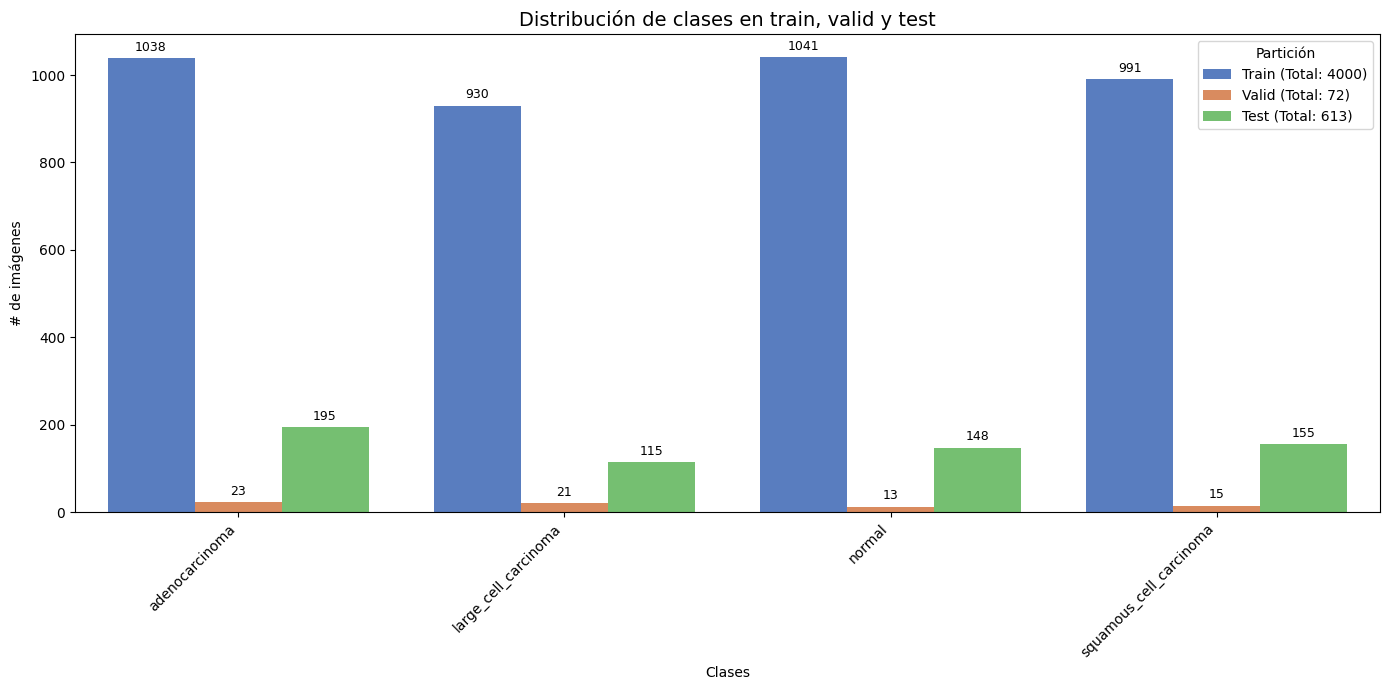

In [11]:
plot_class_distribution({
    "Train": train_counts_named,
    "Valid": val_counts_named,
    "Test": test_counts_named
})

In [46]:
easy_list = EasyImageList.from_multilevel_folder('data/dataset')
easy_list.html(by_class=True, sample=150, size=50)
# VSCode no permite instalar plugins de frontend como JupyterLab, por lo tanto no podés usar extensiones como jupyterlab-hover-image-preview.
HTML("""
<style>
img {
    transition: transform 0.2s ease-in-out;
}
img:hover {
    transform: scale(5.0);
    z-index: 100;
    position: relative;
}
</style>
""")


Drawing test\adenocarcinoma


Drawing test\large_cell_carcinoma


Drawing test\normal


Drawing test\squamous_cell_carcinoma


Drawing train\adenocarcinoma


Drawing train\large_cell_carcinoma


Drawing train\normal


Drawing train\squamous_cell_carcinoma


Drawing valid\adenocarcinoma


Drawing valid\large_cell_carcinoma


Drawing valid\normal


Drawing valid\squamous_cell_carcinoma


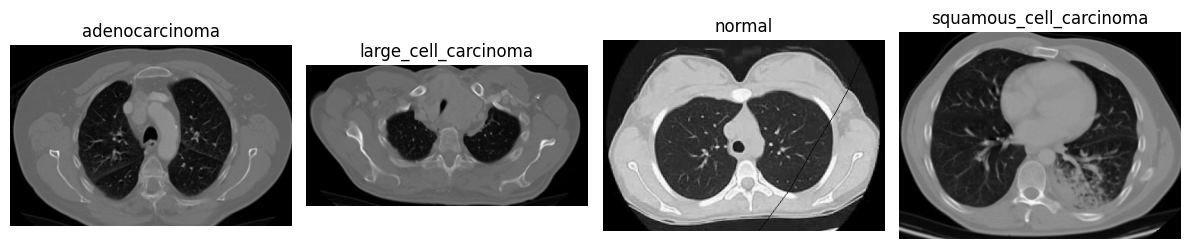

In [12]:
from src.eda import show_first_image_per_class_no_transform

# Mostrar primera imagen por clase sin transformaciones del dataset original
show_first_image_per_class_no_transform(train_dataset)

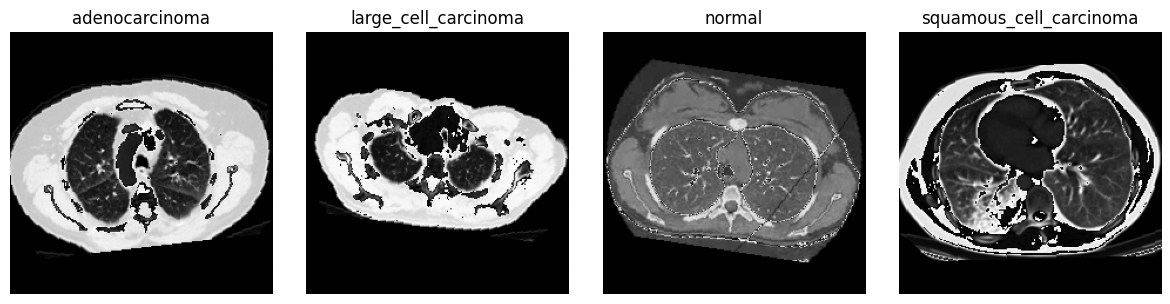

In [13]:
from src.eda import show_first_image_per_class

# Mostrar primera imagen por clase con transformaciones del dataset original
show_first_image_per_class(train_dataset, train_dataset.classes)

## 2. Construcción y entrenamiento del Modelo CNN

En esta sección se presentan dos arquitecturas de redes neuronales convolucionales (CNN) desarrolladas de manera iterativa. Para mejorar la claridad y facilitar la comparación, se agrupan sus definiciones y resultados en un único lugar.

#### Early Stopping

Implementaremos **Early Stopping** para optimizar el tiempo de entrenamiento y evitar sobreajuste. Este mecanismo detiene el entrenamiento cuando no se observa una mejora significativa en la función de pérdida del conjunto de validación durante un número consecutivo de épocas, definido por el parámetro *patience*.

**Funcionamiento:**
1. **Patience**: Es el número de épocas consecutivas sin mejora aceptable en la pérdida antes de detener el entrenamiento.
2. **min_delta**: Define la mejora mínima requerida en la pérdida para considerar que el modelo está progresando. Si la pérdida de validación no mejora al menos en `min_delta` respecto a la mejor pérdida registrada, se incrementa el contador de paciencia.
3. **Detención**: Si el contador de paciencia alcanza el valor de *patience*, el entrenamiento se detiene automáticamente.

De esta manera nos aseguramos que el modelo no siga entrenándose innecesariamente cuando ya no está mejorando.

Esta implementación se encuentra en *src/early_stopping.py*.

#### Función de entrenamiento

La función de entrenamiento se integra con la clase **Early Stopping** para detener el proceso de entrenamiento cuando no se observan mejoras significativas en la pérdida del conjunto de validación durante un número consecutivo de épocas.

**Mejoras implementadas:**
1. **Guardado del mejor modelo**:
    - Se agrega el parámetro `model_name` para guardar los pesos del modelo con el mejor desempeño en validación. Esto permite cargar el modelo posteriormente para evaluación o inferencia.

2. **Persistencia de resultados**:
    - Se introduce el parámetro `results_file` para guardar las métricas de entrenamiento y validación (pérdida, accuracy y F1 score) en un archivo JSON. Esto facilita el análisis y la visualización de los resultados sin necesidad de reentrenar.

3. **Cálculo de F1 Score**:
    - Se incluye el cálculo del **F1 score weighted**, una métrica más robusta que considera el desbalance de clases.

4. **Regularización con Weight Decay**:
    - Se agrega soporte para **weight decay** en el optimizador mediante un parámetro booleano (`weight_decay`). WD penaliza los pesos grandes en el modelo, ayudando a reducir el sobreajuste. Se utiliza en la última variante del modelo entrenado.

Esta implementación se encuentra en *src/training.py*

#### Entrenamiento

Desacoplamos los plots de entrenamiento para poder cambiar la estetica sin reentrenar. Además, persistimos esa información en un JSON file y tambien guardamos el mejor modelo (entre todas las epocas) para utilizar luego evitando el overfitting si Early Stopping tuviese un parámetro de paciencia alto.

In [14]:
from src.training import fit
from src.cnns import CNN as CNN1
from src.training import plot_train_results_from_json

# Canales de entrada es 1 por que son imágenes en escala de grises
# Canales de salida es 4 por que son 4 clases
cnn = CNN1(n_channels=1 , n_outputs=4)

# Entrenamos CNN1
fit(cnn, train_loader=train_loader, eval_loader=val_loader, epochs=30, model_name='data/cnn_1_weights.pth', results_file='data/cnn_1_train_results.json')   

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3

val_loss 1.01037 val_acc 0.64844: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch 1/30 loss 1.55130 val_loss 1.01037 acc 0.44296 val_acc 0.64844 train_f1 0.43982 val_f1 0.25779
Mejor modelo guardado en la época 1 con val_loss 1.01037
Mejor modelo guardado.


val_loss 0.96647 val_acc 0.53125: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 2/30 loss 0.99145 val_loss 0.96647 acc 0.50818 val_acc 0.53125 train_f1 0.49534 val_f1 0.25906
Mejor modelo guardado en la época 2 con val_loss 0.96647
Mejor modelo guardado.


val_loss 0.85879 val_acc 0.71094: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch 3/30 loss 0.93037 val_loss 0.85879 acc 0.56374 val_acc 0.71094 train_f1 0.55372 val_f1 0.42652
Mejor modelo guardado en la época 3 con val_loss 0.85879
Mejor modelo guardado.


val_loss 0.78191 val_acc 0.65625: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


Epoch 4/30 loss 0.77273 val_loss 0.78191 acc 0.65724 val_acc 0.65625 train_f1 0.65159 val_f1 0.59931
Mejor modelo guardado en la época 4 con val_loss 0.78191
Mejor modelo guardado.


val_loss 0.71668 val_acc 0.75781: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


Epoch 5/30 loss 0.68261 val_loss 0.71668 acc 0.71280 val_acc 0.75781 train_f1 0.70712 val_f1 0.54327
Mejor modelo guardado en la época 5 con val_loss 0.71668
Mejor modelo guardado.


val_loss 0.74960 val_acc 0.73438: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


Epoch 6/30 loss 0.52492 val_loss 0.74960 acc 0.78175 val_acc 0.73438 train_f1 0.77704 val_f1 0.72651


val_loss 0.61441 val_acc 0.82812: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


Epoch 7/30 loss 0.49030 val_loss 0.61441 acc 0.78943 val_acc 0.82812 train_f1 0.78618 val_f1 0.79498
Mejor modelo guardado en la época 7 con val_loss 0.61441
Mejor modelo guardado.


val_loss 0.62926 val_acc 0.77344: 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


Epoch 8/30 loss 0.43351 val_loss 0.62926 acc 0.82019 val_acc 0.77344 train_f1 0.81836 val_f1 0.70445


val_loss 0.61681 val_acc 0.79688: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


Epoch 9/30 loss 0.38573 val_loss 0.61681 acc 0.84276 val_acc 0.79688 train_f1 0.84204 val_f1 0.62871


val_loss 0.46370 val_acc 0.85156: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


Epoch 10/30 loss 0.32561 val_loss 0.46370 acc 0.87798 val_acc 0.85156 train_f1 0.87723 val_f1 0.72877
Mejor modelo guardado en la época 10 con val_loss 0.46370
Mejor modelo guardado.


val_loss 0.51776 val_acc 0.82812: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


Epoch 11/30 loss 0.30251 val_loss 0.51776 acc 0.87971 val_acc 0.82812 train_f1 0.87777 val_f1 0.79658


val_loss 0.56628 val_acc 0.84375: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


Epoch 12/30 loss 0.27825 val_loss 0.56628 acc 0.89311 val_acc 0.84375 train_f1 0.89275 val_f1 0.72611


val_loss 0.52708 val_acc 0.85938: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


Epoch 13/30 loss 0.21133 val_loss 0.52708 acc 0.92188 val_acc 0.85938 train_f1 0.92103 val_f1 0.75446


val_loss 0.41433 val_acc 0.86719: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Epoch 14/30 loss 0.20095 val_loss 0.41433 acc 0.92684 val_acc 0.86719 train_f1 0.92668 val_f1 0.76948
Mejor modelo guardado en la época 14 con val_loss 0.41433
Mejor modelo guardado.


val_loss 0.58158 val_acc 0.85156: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


Epoch 15/30 loss 0.17509 val_loss 0.58158 acc 0.93403 val_acc 0.85156 train_f1 0.93381 val_f1 0.83716


val_loss 0.56271 val_acc 0.90625: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


Epoch 16/30 loss 0.15245 val_loss 0.56271 acc 0.94370 val_acc 0.90625 train_f1 0.94307 val_f1 0.82990


val_loss 0.49186 val_acc 0.89844: 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


Epoch 17/30 loss 0.14864 val_loss 0.49186 acc 0.94320 val_acc 0.89844 train_f1 0.94338 val_f1 0.82173


val_loss 0.44853 val_acc 0.89844: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Epoch 18/30 loss 0.13472 val_loss 0.44853 acc 0.94792 val_acc 0.89844 train_f1 0.94852 val_f1 0.82388


val_loss 0.48096 val_acc 0.89844: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


Epoch 19/30 loss 0.14973 val_loss 0.48096 acc 0.94370 val_acc 0.89844 train_f1 0.94324 val_f1 0.82455


val_loss 0.43470 val_acc 0.91406: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


Epoch 20/30 loss 0.13818 val_loss 0.43470 acc 0.94965 val_acc 0.91406 train_f1 0.94939 val_f1 0.84441


val_loss 0.78633 val_acc 0.81250: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Epoch 21/30 loss 0.11668 val_loss 0.78633 acc 0.95635 val_acc 0.81250 train_f1 0.95615 val_f1 0.76520


val_loss 0.60328 val_acc 0.87500: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Epoch 22/30 loss 0.13412 val_loss 0.60328 acc 0.94940 val_acc 0.87500 train_f1 0.94953 val_f1 0.78007


val_loss 0.62482 val_acc 0.90625: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Epoch 23/30 loss 0.11599 val_loss 0.62482 acc 0.95982 val_acc 0.90625 train_f1 0.95938 val_f1 0.83714


val_loss 0.55668 val_acc 0.80469: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Epoch 24/30 loss 0.09010 val_loss 0.55668 acc 0.96925 val_acc 0.80469 train_f1 0.96893 val_f1 0.84718


val_loss 0.69290 val_acc 0.83594: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


Epoch 25/30 loss 0.08924 val_loss 0.69290 acc 0.97098 val_acc 0.83594 train_f1 0.97071 val_f1 0.80853


val_loss 0.55888 val_acc 0.91406: 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

Epoch 26/30 loss 0.08173 val_loss 0.55888 acc 0.97346 val_acc 0.91406 train_f1 0.97397 val_f1 0.85184
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([np.float64(1.5512970175061906),
  np.float64(0.9914545341143532),
  np.float64(0.9303746819496155),
  np.float64(0.7727299815132505),
  np.float64(0.682605567905638),
  np.float64(0.5249237848652734),
  np.float64(0.49030278031788177),
  np.float64(0.4335087507017075),
  np.float64(0.38572612239254844),
  np.float64(0.32561375271706355),
  np.float64(0.30251307548984646),
  np.float64(0.2782455259372318),
  np.float64(0.2113305199004355),
  np.float64(0.20095285542664074),
  np.float64(0.1750896315844286),
  np.float64(0.15244529975785148),
  np.float64(0.1486367874202274),
  np.float64(0.13472465496687663),
  np.float64(0.14973205132853418),
  np.float64(0.1381807422176713),
  np.float64(0.11668158854757037),
  np.float64(0.13411731201977956),
  np.float64(0.11598951407959537),
  np.float64(0.0900950621044825),
  np.float64(0.0892409550779987),
  np.float64(0.08173134475798598)],
 [np.float64(1.010372519493103),
  np.float64(0.9664728045463562),
  np.float64(0.8587878942489624),
  n

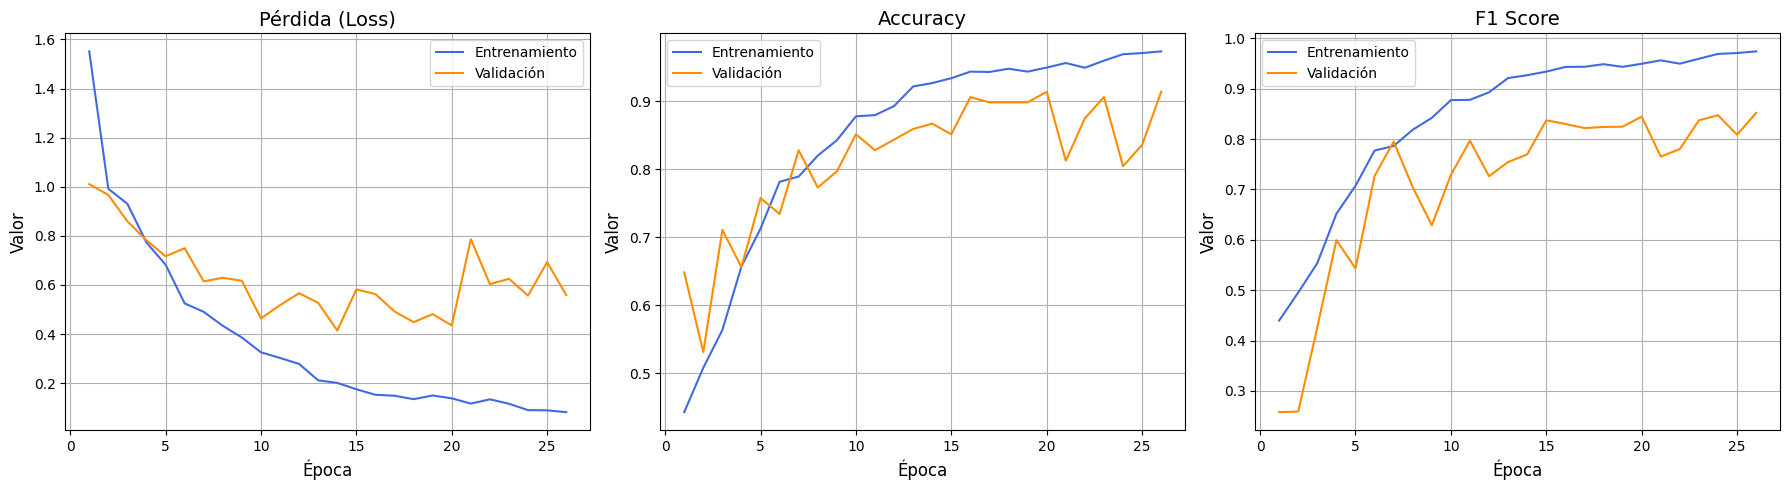

In [18]:
plot_train_results_from_json(json_file='data/cnn_1_train_results.json')

In [ ]:
# Entrenamos CNN 2
# fit(model=model, train_loader=train_loader, eval_loader=val_loader, epochs=80, model_name='data/cnn_2_weights.pth', results_file='data/cnn_2_train_results.json')

In [ ]:
# plot_train_results_from_json(json_file='cnn_train_data.json')

## 3. Evaluación de Modelos

Completar

### Evaluación

In [29]:
# Se carga el modelo final
model = CNN1(n_channels=1, n_outputs=4)
model.to(device)
# Se carga el modelo final desde el archivo que se generó durante el entrenamiento
model.load_state_dict(torch.load('data/cnn_1_weights.pth', map_location=device))
model.eval()  # Configurar el modelo en modo evaluación
print("Modelo cargado correctamente.")

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3

`evaluate_model` evalúa el rendimiento de un modelo entrenado en un dataset de test y genera métricas para analizar su desempeño.

#### **Parámetros**
- **`model`**: Modelo entrenado que se evaluará.
- **`data_loader`**: DataLoader que contiene el conjunto de datos de prueba.
- **`class_names`**: Lista con los nombres de las clases del problema.
- **`device`**: Dispositivo en el que se ejecutará la evaluación (`'cpu'` o `'cuda'`).
- **`output_file`**: Nombre del archivo JSON donde se guardarán los resultados de la evaluación.

#### **Lógica**
1. **Modo evaluación**: Configura el modelo en modo evaluación (`model.eval()`) para desactivar el cálculo de gradientes.
2. **Inferencia**:
    - Recorre el DataLoader y realiza predicciones para cada batch.
    - Almacena las predicciones y etiquetas para calcular métricas.
3. **Cálculo de métricas**:
    - **Matriz de confusión**: Se genera tanto en valores absolutos como normalizados.
    - **Reporte de clasificación**: Incluye precisión, recall y F1-score por clase.
4. **Visualización**:
    - Se generan gráficos de las matrices de confusión (absoluta y normalizada).
5. **Resultados**:
    - Los resultados se guardan en un archivo JSON para análisis posterior.

#### **Salida de la función**
- Imprime las métricas calculadas.
- Genera gráficos de las matrices de confusión.
- Guarda los resultados en un archivo JSON que pueden ser utilizados luego para análisis y comparación.

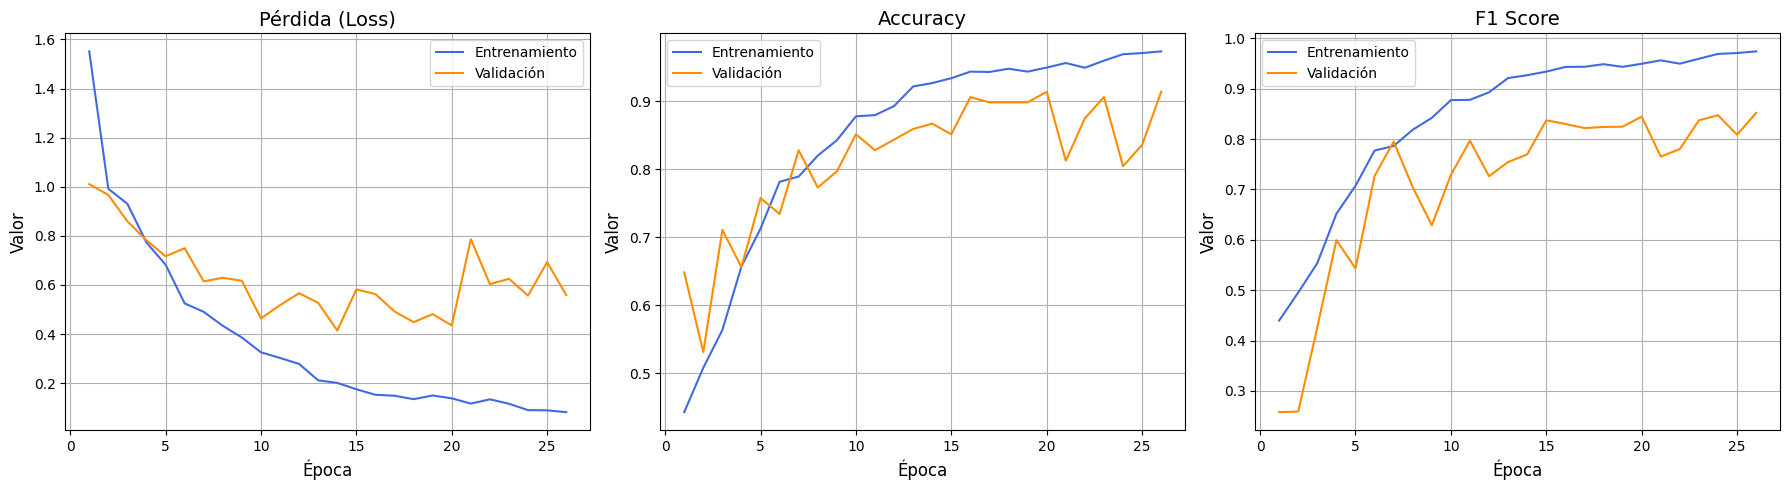

In [27]:
plot_train_results_from_json(json_file='data/cnn_1_train_results.json')

Resultados guardados en data/cnn_1_evaluation_results.json


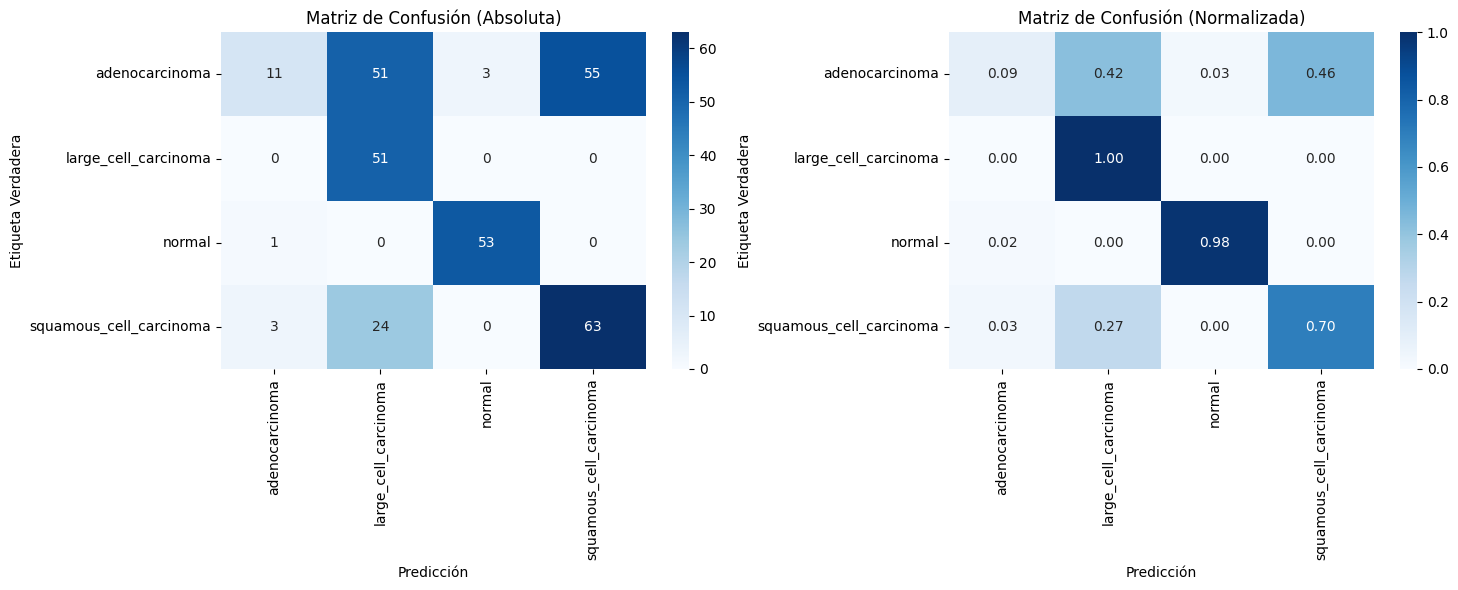

In [30]:
from src.evaluation import evaluate_model

evaluate_model(model, test_loader, test_dataset.classes, device, output_file='data/cnn_1_evaluation_results.json')

`generate_classification_report` evalúa el modelo entrenado en dataset y genera métricas de evaluación.

#### **Parámetros**
- **`model`**: Modelo entrenado que se evaluará.
- **`data_loader`**: DataLoader que contiene el conjunto de datos de prueba.
- **`class_names`**: Lista con los nombres de las clases del problema.
- **`device`**: Dispositivo en el que se ejecutará la evaluación (`'cpu'` o `'cuda'`). Este parámetro esta definido al comienzo del trabajo.

#### **Lógica**
1. **Modo evaluación**: Configura el modelo en modo evaluación (`model.eval()`) para desactivar el cálculo de gradientes.
2. **Inferencia**:
    - Recorre el DataLoader y realiza predicciones para cada batch.
    - Calcula la pérdida acumulada utilizando la función de pérdida `CrossEntropyLoss`.
    - Almacena predicciones y etiquetas para calcular métricas.
3. **Cálculo de métricas**:
    - **Accuracy**
    - **F1 Score (weighted)**
    - **Reporte de clasificación**
    - **Pérdida promedio**

#### **Salida de la función**
- Imprime el reporte de clasificación, accuracy, F1 score y pérdida promedio.
- Devuelve un diccionario con las métricas calculadas.


In [31]:
from src.evaluation import generate_classification_report

results = generate_classification_report(model, test_loader, test_dataset.classes, device)

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.73      0.09      0.16       120
   large_cell_carcinoma       0.40      1.00      0.58        51
                 normal       0.95      0.98      0.96        54
squamous_cell_carcinoma       0.53      0.70      0.61        90

               accuracy                           0.57       315
              macro avg       0.65      0.69      0.58       315
           weighted avg       0.66      0.57      0.49       315

Accuracy: 0.5651
F1 Score (weighted): 0.4937
Loss: 1.4835


## 4. Transfer Learning

Completar

## 5. Conclusiones

Completar